In [21]:
import pickle
import os
import numpy as np
import sklearn
import sklearn.preprocessing
import torch
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def get_data_labels(dict_):
    dict_decoded_ = {}
    for key,value in dict_.items():
            if(isinstance(key,bytes)):
                key_new = key.decode('ascii')
            if(isinstance(value,bytes)):
                value = value.decode('ascii')
            dict_decoded_[key_new] = value
    return dict_decoded_['data'],dict_decoded_['labels']

In [3]:
# loading dataset files
path = 'C:/Users/emnsrjm/Desktop/Courses/Machine Learning/Project/Project/Machine-Learning-Project/Classifier interpretability/models/cifar-10-python/cifar-10-batches-py/'
files = os.listdir(path)
X_train=[]
y_train=[]
for name in files:
    if 'data_batch' in name:
        dict_ = unpickle(path+name)  # unpickling the data_batch file
        X_temp,y_temp = get_data_labels(dict_)  # getting data and labels from unpickled data
        X_train.append(X_temp)
        y_train.append(y_temp)
X_train = np.asarray(X_train).astype(np.uint8).reshape(50000,3072)
y_train = np.asarray(y_train).astype(np.int32).reshape(50000)
X_train = X_train/255.0

In [4]:
# load test data
dict_ = unpickle(path+'test_batch')  # unpickling the test_batch file
X_test,y_test = get_data_labels(dict_)  # getting data and labels from unpickled data

X_test = np.asarray(X_test).astype(np.uint8).reshape(10000,3072)
y_test = np.asarray(y_test).astype(np.int32).reshape(10000)
X_test = X_test/255.0

In [5]:
# scale the data
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)

y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

In [6]:
# reshaping tensors for CNN
X_train_tensor = X_train_tensor.reshape(50000,3,32,32)
X_test_tensor = X_test_tensor.reshape(-1,3,32,32)
print(X_train_tensor.shape)
y_train_tensor = y_train_tensor.reshape(50000)
print(y_train_tensor.shape)
y_test_tensor = y_test_tensor.reshape(-1)
print(y_test_tensor.shape)

torch.Size([50000, 3, 32, 32])
torch.Size([50000])
torch.Size([10000])


In [7]:
# preparing the model
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

num_filters = 5
filter_size_1 = 4
filter_size_2 = 6
pool_size = 2

model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3,
                    out_channels=num_filters,
                    kernel_size=filter_size_1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=num_filters,
                    out_channels=filter_size_2,
                    kernel_size=filter_size_2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
    torch.nn.Flatten(),
    torch.nn.Linear(filter_size_2 * 12**2, 10),
)

In [8]:
batch_size = 100
num_epoch = 13

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0060,momentum=0.9)

In [9]:
# loss would be 1.0937 in the last epoch
for epoch in range(1, num_epoch+1):
    for i in range(0, len(X_train_tensor), batch_size):        
        X = X_train_tensor[i:i+batch_size]
        y = y_train_tensor[i:i+batch_size]

        y_pred = model(X.float())
        l = loss(y_pred, y.long())
        
        model.zero_grad()
        l.backward()
        optimizer.step()
        
    print("Epoch %d final minibatch had loss %.4f" % (epoch, l.item()))

Epoch 1 final minibatch had loss 1.6065
Epoch 2 final minibatch had loss 1.5060
Epoch 3 final minibatch had loss 1.4220
Epoch 4 final minibatch had loss 1.3652
Epoch 5 final minibatch had loss 1.3126
Epoch 6 final minibatch had loss 1.2573
Epoch 7 final minibatch had loss 1.1978
Epoch 8 final minibatch had loss 1.1647
Epoch 9 final minibatch had loss 1.1392
Epoch 10 final minibatch had loss 1.1192
Epoch 11 final minibatch had loss 1.0889
Epoch 12 final minibatch had loss 1.0945
Epoch 13 final minibatch had loss 1.0880


In [11]:
# save the model to disk
filename = 'cnnCifarModel.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# calculate training accuracy
from sklearn.metrics import accuracy_score
with torch.no_grad():
    y_pred = model(X_train.float())
    
softmax = torch.exp(y_pred).cpu()
prob = list(softmax.numpy())
y_pred = np.argmax(prob, axis=1)

accuracy = accuracy_score(y_train, y_pred) * 100
# accuracy on training set
print('Training accuracy is '+str(accuracy)

In [ ]:
# calculate test accuracy
with torch.no_grad():
    y_test_pred = model(X_test.float())
    
softmax = torch.exp(y_test_pred).cpu()
prob = list(softmax.numpy())
y_test_pred = np.argmax(prob, axis=1)

# accuracy on training set
accuracy = accuracy_score(y_test, y_test_pred) * 100
print('Testing accuracy is '+str(accuracy))

In [18]:
#Reference : Lab 9 of COMP6321 by Prof Andrew Delong
def plot_matrix_grid(V, cmap='bwr'):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    The default cmap is "bwr" (blue-white-red) but can also be "gray".
    """
    if isinstance(V, torch.Tensor):
        V = V.detach().numpy()
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmax = np.percentile(np.abs(V), [99.9])      # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap(cmap))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axes.flat[len(V):]:
        ax.set_axis_off()
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right 

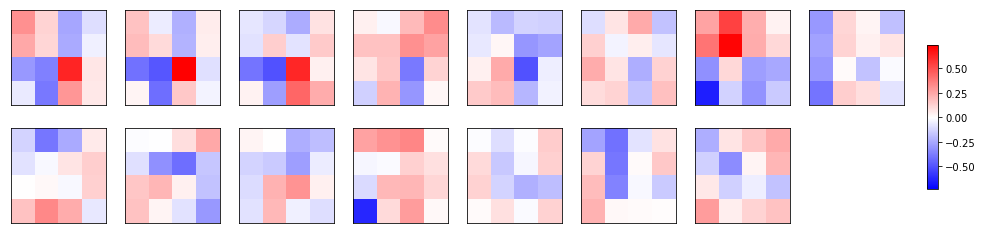

In [22]:
# Your code here. Aim for 2-3 lines.
W1, b1, W2, b2,W3,b3 = model.parameters()
plot_matrix_grid(W1.reshape(-1, filter_size_1, filter_size_1))

In [35]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()
param_distribution = {'criterion':['gini','entropy'], 'max_depth': range(1,10,2)}

gridcv = GridSearchCV(model, param_distribution, verbose=1, n_jobs=4, cv=3)
gridcv.fit(X_train, y_train)
grid_accuracy_test  = sklearn.metrics.accuracy_score(y_test,  gridcv.best_estimator_.predict(X_test))
accuracy = grid_accuracy_test*100
print("Accuracy : "+str(accuracy))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 16.5min finished


Accuracy : 30.459999999999997


In [37]:
# save the model to disk
filename = 'decision_tree.sav'
pickle.dump(gridcv.best_estimator_, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [7]:
import pickle
loaded_model = pickle.load(open('decision_tree.sav', 'rb'))
list_ = ['airplane','sfs','asa','sdfasdf','sdfsdf','sdfsd']
#sklearn.tree.plot_tree(loaded_model, max_depth=2,feature_names=['x1', 'x2']);
from sklearn.tree import export_graphiz
import graphiz
export_graphiz(gridcv.best_estimator_,out_file='dtc.dot',class_names=list_)
with open('dtc.dot') as f:
    graph = f.read()
graphiz.Source(graph)

c:\users\emnsrjm\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\emnsrjm\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ImportError: cannot import name 'export_graphiz' from 'sklearn.tree' (c:\users\emnsrjm\appdata\local\programs\python\python37\lib\site-packages\sklearn\tree\__init__.py)